## 1. Prepare the environment

In [1]:
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install zeroconf
%pip install --q moku[neuralnetwork]


Note: you may need to restart the kernel to use updated packages.


Import the Python libraries

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import moku
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import time


In [3]:
try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

Define the relevant functions

In [5]:
def load_data_from_csv(filename):
    data_windows = []

    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip header if it exists

        for row in reader:
            if len(row) < 2:
                continue  # Skip malformed rows
            # Split the 'data' field and convert back to floats
            float_values = [float(x) for x in row[1].split(';')]
            data_windows.append(float_values)

    return data_windows


## 2. Define the model for the "Identity" Neural Network

In [21]:
# Read from the saved files
# Note that the Identity NN won't be trained, as we are hardcoding the weights, but a training dataset is required in the LINN model definition
data_filename = 'AD_dataset/data_training_ad_576592.csv' 
data = load_data_from_csv(data_filename)
data = np.array(data)

In [22]:
quant_mod_identity = LinnModel()

In [23]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [24]:
frame_length = len(data[0])

# Define the identity model — just a single linear layer with input dimension matching frame_length
quant_mod_identity.set_training_data(data, data, scale=False)
model_definition = [(frame_length, 'linear')]

# Build the identity model
quant_mod_identity.construct_model(model_definition)

# Manually set weights to identity
identity_matrix = np.eye(frame_length, dtype=np.float32)
zero_bias = np.zeros(frame_length, dtype=np.float32)


dense_layer = quant_mod_identity.model.layers[1]
dense_layer.set_weights([identity_matrix, zero_bias])

dense_layer.trainable = False


In [25]:
model_filename = 'AD_model_identity.linn'
T = np.linspace(-1, 1, frame_length)
save_linn(quant_mod_identity, input_channels=1, output_channels=1, file_name=model_filename, output_mapping=[T.size-1])

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 103 cycles


# 3. Testing the model

In [26]:
print(type(data))
try:
    print(data.shape)
except AttributeError:
    print("No shape attribute, likely not a NumPy array or tensor.")

<class 'numpy.ndarray'>
(1100, 100)


In [27]:
reconstructions = []
reconstructions = quant_mod_identity.predict(data)

 1/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Visualize different frames by changing the frame_id below

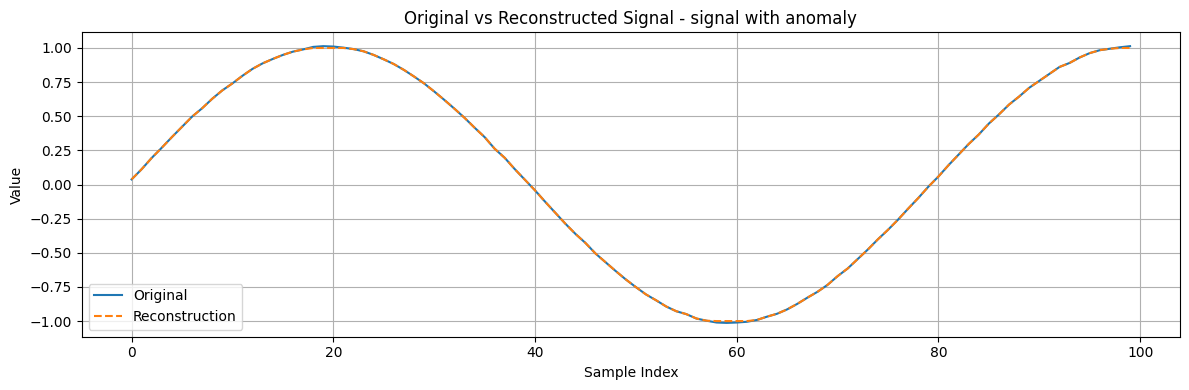

In [32]:
frame_id = 0

plt.figure(figsize=(12, 4))
plt.plot(data[frame_id_anomaly], label='Original')
plt.plot(reconstructions[frame_id_anomaly], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - signal with anomaly')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()
